#Download Dataset from Kaggle

In [1]:
 !pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10/kaggle-1.5.10-cp37-none-any.whl
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"petarvasiljevic","key":"dae47a988e82509cb90196d0de28fc56"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip cell-images-for-detecting-malaria.zip -d malaria-detection

Streaming output truncated to the last 5000 lines.
  inflating: malaria-detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: malaria-detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: malaria-detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: malaria-detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: malaria-detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: malaria-detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: malaria-detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: malaria-detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: malaria-detection/cell_images/cell_images/Uninfe

In [19]:
#For some reason, inside of cell_images folder is additional cell_images folder
import shutil
shutil.rmtree('malaria-detection/cell_images/cell_images', ignore_errors=True)

#Import libraries

In [6]:
import warnings
warnings.filterwarnings('ignore')

import os
from tqdm import tqdm
import random
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import cv2

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

#Visualize images 

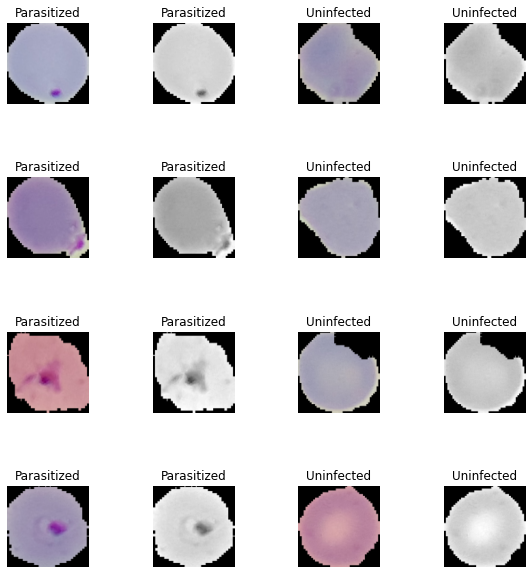

In [ ]:
fig, ax = plt.subplots(4, 4)
for i in range(4):

    #Parasitized images
    image_index = random.randint(0,len(images)//2)
    ax[i, 0].imshow(images[image_index])
    ax[i, 0].set_title(labels[image_index])
    ax[i, 0].axis('off')

    ax[i, 1].imshow(images_gray[image_index], cmap='gray')
    ax[i, 1].set_title(labels[image_index])
    ax[i, 1].axis('off')


    #Uninfected images
    image_index = len(images)//2 + random.randint(0,len(images)//2)
    ax[i, 2].imshow(images[image_index])
    ax[i, 2].set_title(labels[image_index])
    ax[i, 2].axis('off')
    
    ax[i, 3].imshow(images_gray[image_index], cmap='gray')
    ax[i, 3].set_title(labels[image_index])
    ax[i, 3].axis('off')


plt.subplots_adjust(hspace=0.9)
fig.set_size_inches(10,10)

#Create train and test data

In [20]:
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

In [21]:
train_datagen = datagen.flow_from_directory(directory='malaria-detection/cell_images',
                                           target_size=(img_size,img_size),
                                           class_mode = 'binary',
                                           batch_size = 16,
                                           subset='training')

Found 22048 images belonging to 2 classes.


In [22]:
test_datagen = datagen.flow_from_directory(directory='malaria-detection/cell_images',
                                           target_size=(img_size,img_size),
                                           class_mode = 'binary',
                                           batch_size = 16,
                                           subset='validation')

Found 5510 images belonging to 2 classes.


#Create model

In [23]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics= ['accuracy']
)

In [25]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [26]:
history = model.fit_generator(
    generator = train_datagen,
    steps_per_epoch = len(train_datagen),
    epochs = 10,
    validation_data = test_datagen,
    validation_steps=len(test_datagen),
    callbacks=[early_stop]   
)

Epoch 1/10
1378/1378 [==============================] - 504s 365ms/step - loss: 0.6671 - accuracy: 0.5929 - val_loss: 0.3156 - val_accuracy: 0.8904
Epoch 2/10
1378/1378 [==============================] - 492s 357ms/step - loss: 0.2528 - accuracy: 0.9281 - val_loss: 0.1884 - val_accuracy: 0.9426
Epoch 3/10
1378/1378 [==============================] - 490s 356ms/step - loss: 0.1642 - accuracy: 0.9499 - val_loss: 0.1711 - val_accuracy: 0.9407
Epoch 4/10
1378/1378 [==============================] - 491s 357ms/step - loss: 0.1456 - accuracy: 0.9561 - val_loss: 0.1739 - val_accuracy: 0.9401
Epoch 5/10
1378/1378 [==============================] - 492s 357ms/step - loss: 0.1363 - accuracy: 0.9569 - val_loss: 0.1658 - val_accuracy: 0.9475
Epoch 6/10
1378/1378 [==============================] - 492s 357ms/step - loss: 0.1206 - accuracy: 0.9612 - val_loss: 0.1742 - val_accuracy: 0.9445
Epoch 7/10
1378/1378 [==============================] - 495s 359ms/step - loss: 0.1192 - accuracy: 0.9615 - val_

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, None, None, 16)    448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
dropout_4 (Dropout)          (None, None, None, 16)    0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
dropout_5 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)   

#Plot history

Text(0, 0.5, 'Accuracy')

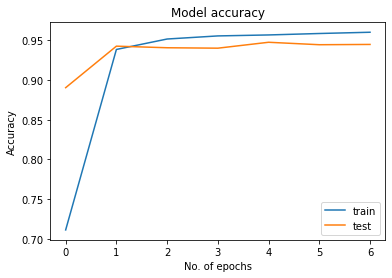

In [30]:
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.title('Model accuracy')
plt.legend(['train','test'])
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

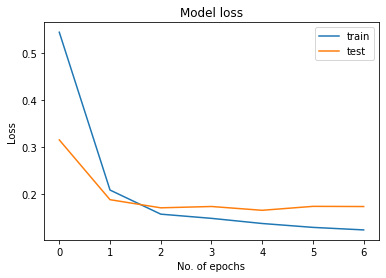

In [31]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model loss')
plt.legend(['train','test'])
plt.xlabel('No. of epochs')
plt.ylabel('Loss')